# Audio resampling in Python

Original notebook by Joachim Thiemann, 11.8.2016, joachim.thiemann@uni-oldenburg.de, see: https://signalsprocessed.blogspot.com/2016/08/audio-resampling-in-python.html?m=0, then forked by Jonas Haag,at https://github.com/jonashaag/audio-resampling-in-python, with more libraries.

I also added some elements from https://github.com/faroit/python_audio_loading_benchmark

---

One of the most basic tasks in audio processing anyone would need to do is resampling audio files; seems like the data you want to process is never sampled in the rate you want. 44.1k? 16k? 8k? Those are the common ones; there are some really odd ones out there.

Resampling is actually quite hard to get right. You need to properly choose your antialias filters, and write a interpolation/decimation procedure that won't introduce too much noise. There have been books written on this topic. For the most part, there is no single univeral way to to this right, since context matters.

For a more detailed discussion on sample rate conversion see the aptly named "Digital Audio Resampling Homepage" [https://ccrma.stanford.edu/~jos/resample/]. Then look at [http://src.infinitewave.ca/] for a super informative comparison of a ton of resampling implementations. No seriously, go there. (It inspired me to compare the methods below using a sine sweep.)

Now for a comparison with pretty pictures.

## Setup

In [1]:
resamp_libs = ['scipy', 
                'resampy_best', 
                'resampy_fast', 
                'torchaudio_hann', 
                'torchaudio_kaiser', 
                'torchaudio_transform_hann', 
                'torchaudio_transform_kaiser', 
                'julius', 
                'soxr', 
                'nnresample']

You can install the required packages like the following:

In [2]:


# !apt-get -qq install -y libsamplerate0-dev
# !pip install -qU samplerate scipy resampy torchaudio julius soxr nnresample
# !pip install -qU git+https://github.com/gregorias/samplerate.git
# !pip install -qU git+https://github.com/danpovey/filtering.git


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# import samplerate  # https://pypi.org/project/samplerate/
# import scikits.samplerate  # https://github.com/gregorias/samplerate
import scipy.signal
import resampy


import lilfilter  # https://github.com/danpovey/filtering
import julius  # https://github.com/adefossez/julius
import soxr  # https://github.com/dofuuz/python-soxr
import nnresample  # https://github.com/jthiem/nnresample

import torch, torchaudio
import torchaudio.functional as F


In [4]:
import sys
!{sys.executable} -m pip freeze | grep -E "samplerate|scipy|resampy|torchaudio|lilfilter|julius|scikits|soxr|nnresample"

julius==0.2.7
lilfilter==0.0.1
nnresample==0.2.4.1
resampy==0.4.2
scipy==1.10.1
soxr==0.3.7
torchaudio==2.1.1


In [5]:
def resample_scipy(sig, P, Q):
    return scipy.signal.resample(sig, int(len(sig)*Q/P))

def resample_resampy_best(sig, P, Q):
    return resampy.resample(sig, P, Q, filter='kaiser_best')

def resample_resampy_fast(sig, P, Q):
    return resampy.resample(sig, P, Q, filter='kaiser_fast')


def resample_torchaudio_hann(sig, P, Q):
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return F.resample(sig, P, Q, resampling_method='sinc_interp_hann')

def resample_torchaudio_kaiser(sig, P, Q):
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return F.resample(sig, P, Q, resampling_method='sinc_interp_kaiser')

def resample_torchaudio_transform_hann(sig, P, Q, get_resampler=False):
    
    resampler = torchaudio.transforms.Resample(
        P,
        Q,
        resampling_method='sinc_interp_hann',
)
    if get_resampler:
        return resampler
    
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return resampler(sig)

def resample_torchaudio_transform_kaiser(sig, P, Q, get_resampler=False):
    resampler = torchaudio.transforms.Resample(
        P,
        Q,
        resampling_method='sinc_interp_kaiser',
)
    if get_resampler:
        return resampler
    # Convert to torch if numpy
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float()
    return resampler(sig)


def resample_julius(sig, P, Q):
    # If numpy convert to torch
    if isinstance(sig, np.ndarray):
        sig = torch.from_numpy(sig).float() 
    return julius.resample_frac(sig, P, Q)

def resample_soxr(sig, P, Q):
    return soxr.resample(sig, P, Q)

def resample_nnresample(sig, P, Q):
    return nnresample.resample(sig, Q, P)


---

## Downsampling a sweep

A common task is to convert between the CD sampling rate of 44.1 kHz, and the multiples of 8kHz that originated from the telekon industry.  In particular, 48kHz.  (Supposedly the rate of 44.1k was chosen in part _because_ is was difficult to convert to 48 kHz; but it is also connected to NTSC timing).  So let's have a sweep sampled at 48 kHz.

In [6]:
VMIN = -150

P = 48000
Q = 44100

offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/P
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase, dtype=np.float64)

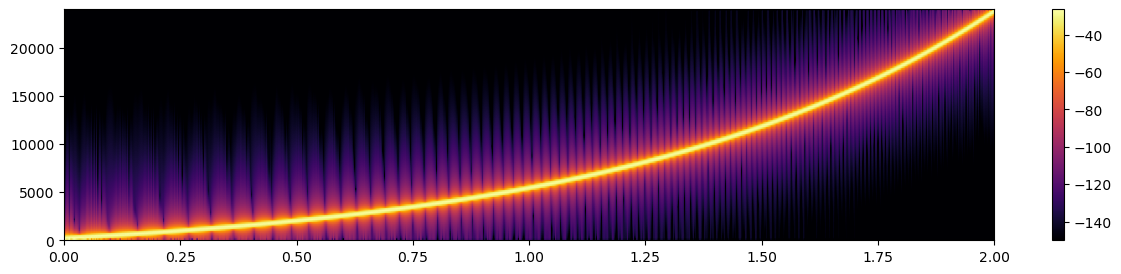

In [7]:
plt.figure(figsize=(15,3))
plt.specgram(sig, scale='dB', Fs=P, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,P/2))

Now convert it to 44.1 kHz using the different libraries, and plot the spectrograms.

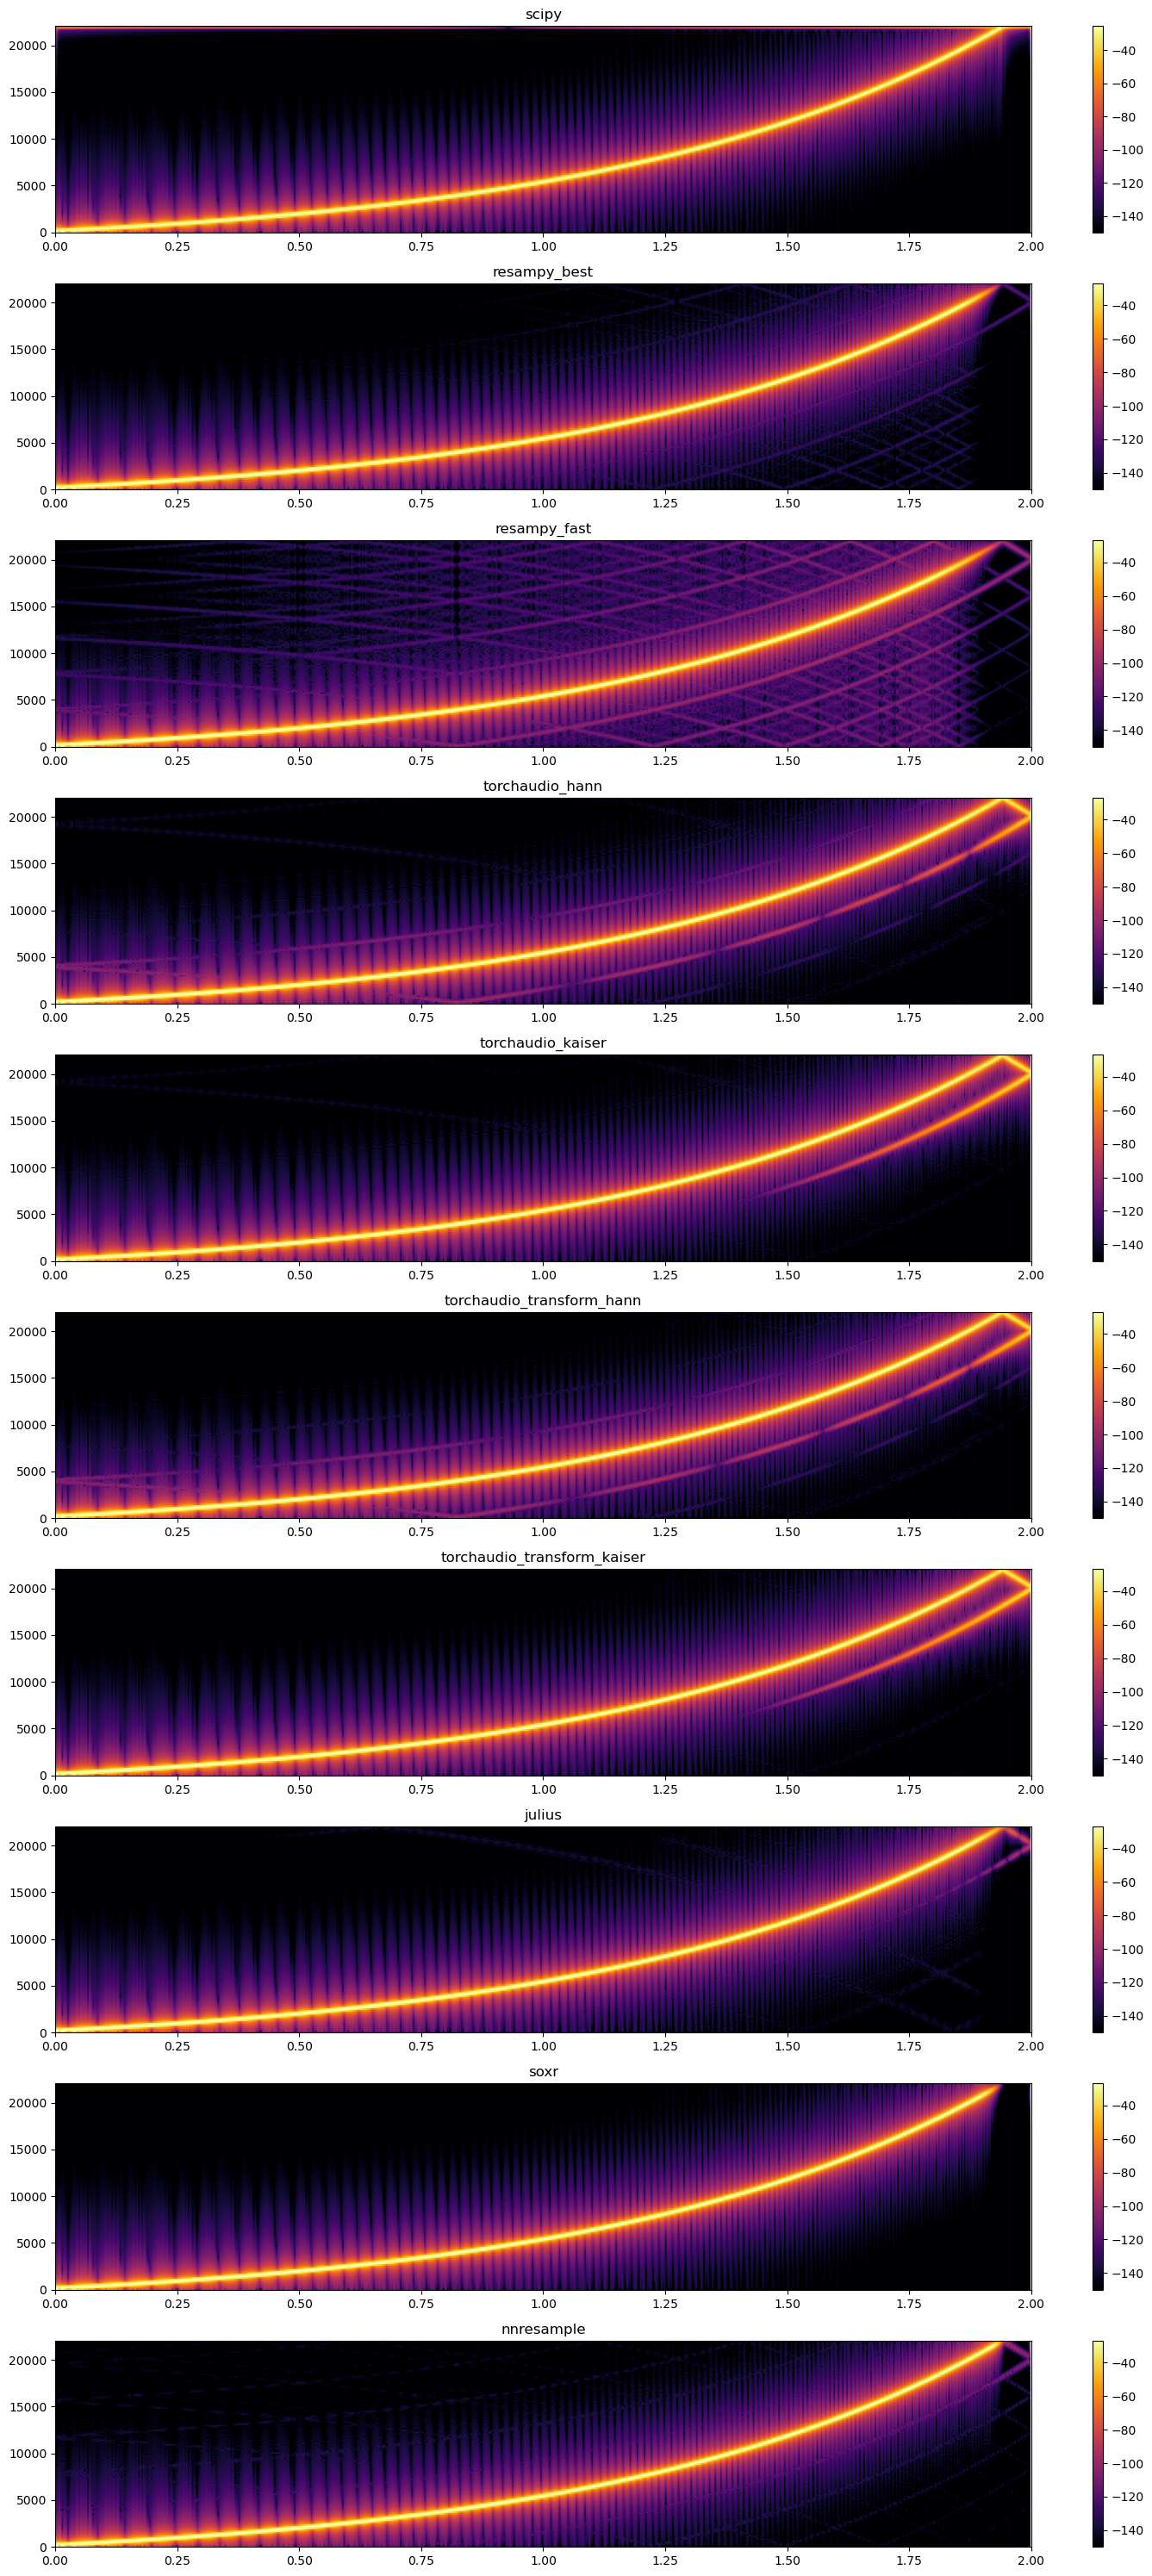

In [8]:
# Upsample using all methods and plot in different subplots

libs = resamp_libs # Change this to select which libraries to use

plt.figure(figsize=(15,30))
for i, lib in enumerate(libs):
    plt.subplot(len(libs), 1, i+1)
    # if torchaudio or julius convert to torch
    _sig = sig
    if lib.startswith('torchaudio') or lib.startswith('julius'):
        _sig = torch.from_numpy(sig).float()
        
    plt.specgram(eval(f'resample_{lib}(_sig, P, Q)'), scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
    plt.colorbar()
    plt.axis((0,2,0,Q/2))
    plt.title(lib)

plt.tight_layout()



---

## Upsampling a sweep

In [9]:
P = 48000
Q = 44100
P,Q = Q,P # <== upsampling

offset = 2000
instfreq = np.exp(np.linspace(np.log(offset+100), np.log(offset+23900), 96000))-offset
deltaphase = 2*np.pi*instfreq/P
cphase = np.cumsum(deltaphase)
sig = np.sin(cphase)

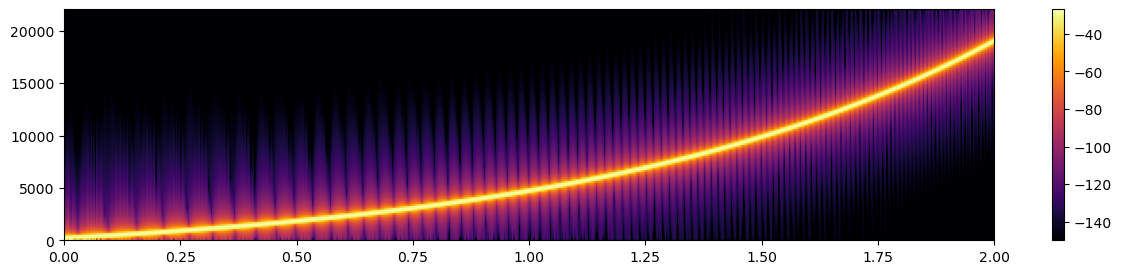

In [10]:
plt.figure(figsize=(15,3))
plt.specgram(sig, scale='dB', Fs=P, vmin=VMIN, cmap='inferno')
plt.colorbar()
_=plt.axis((0,2,0,P/2))

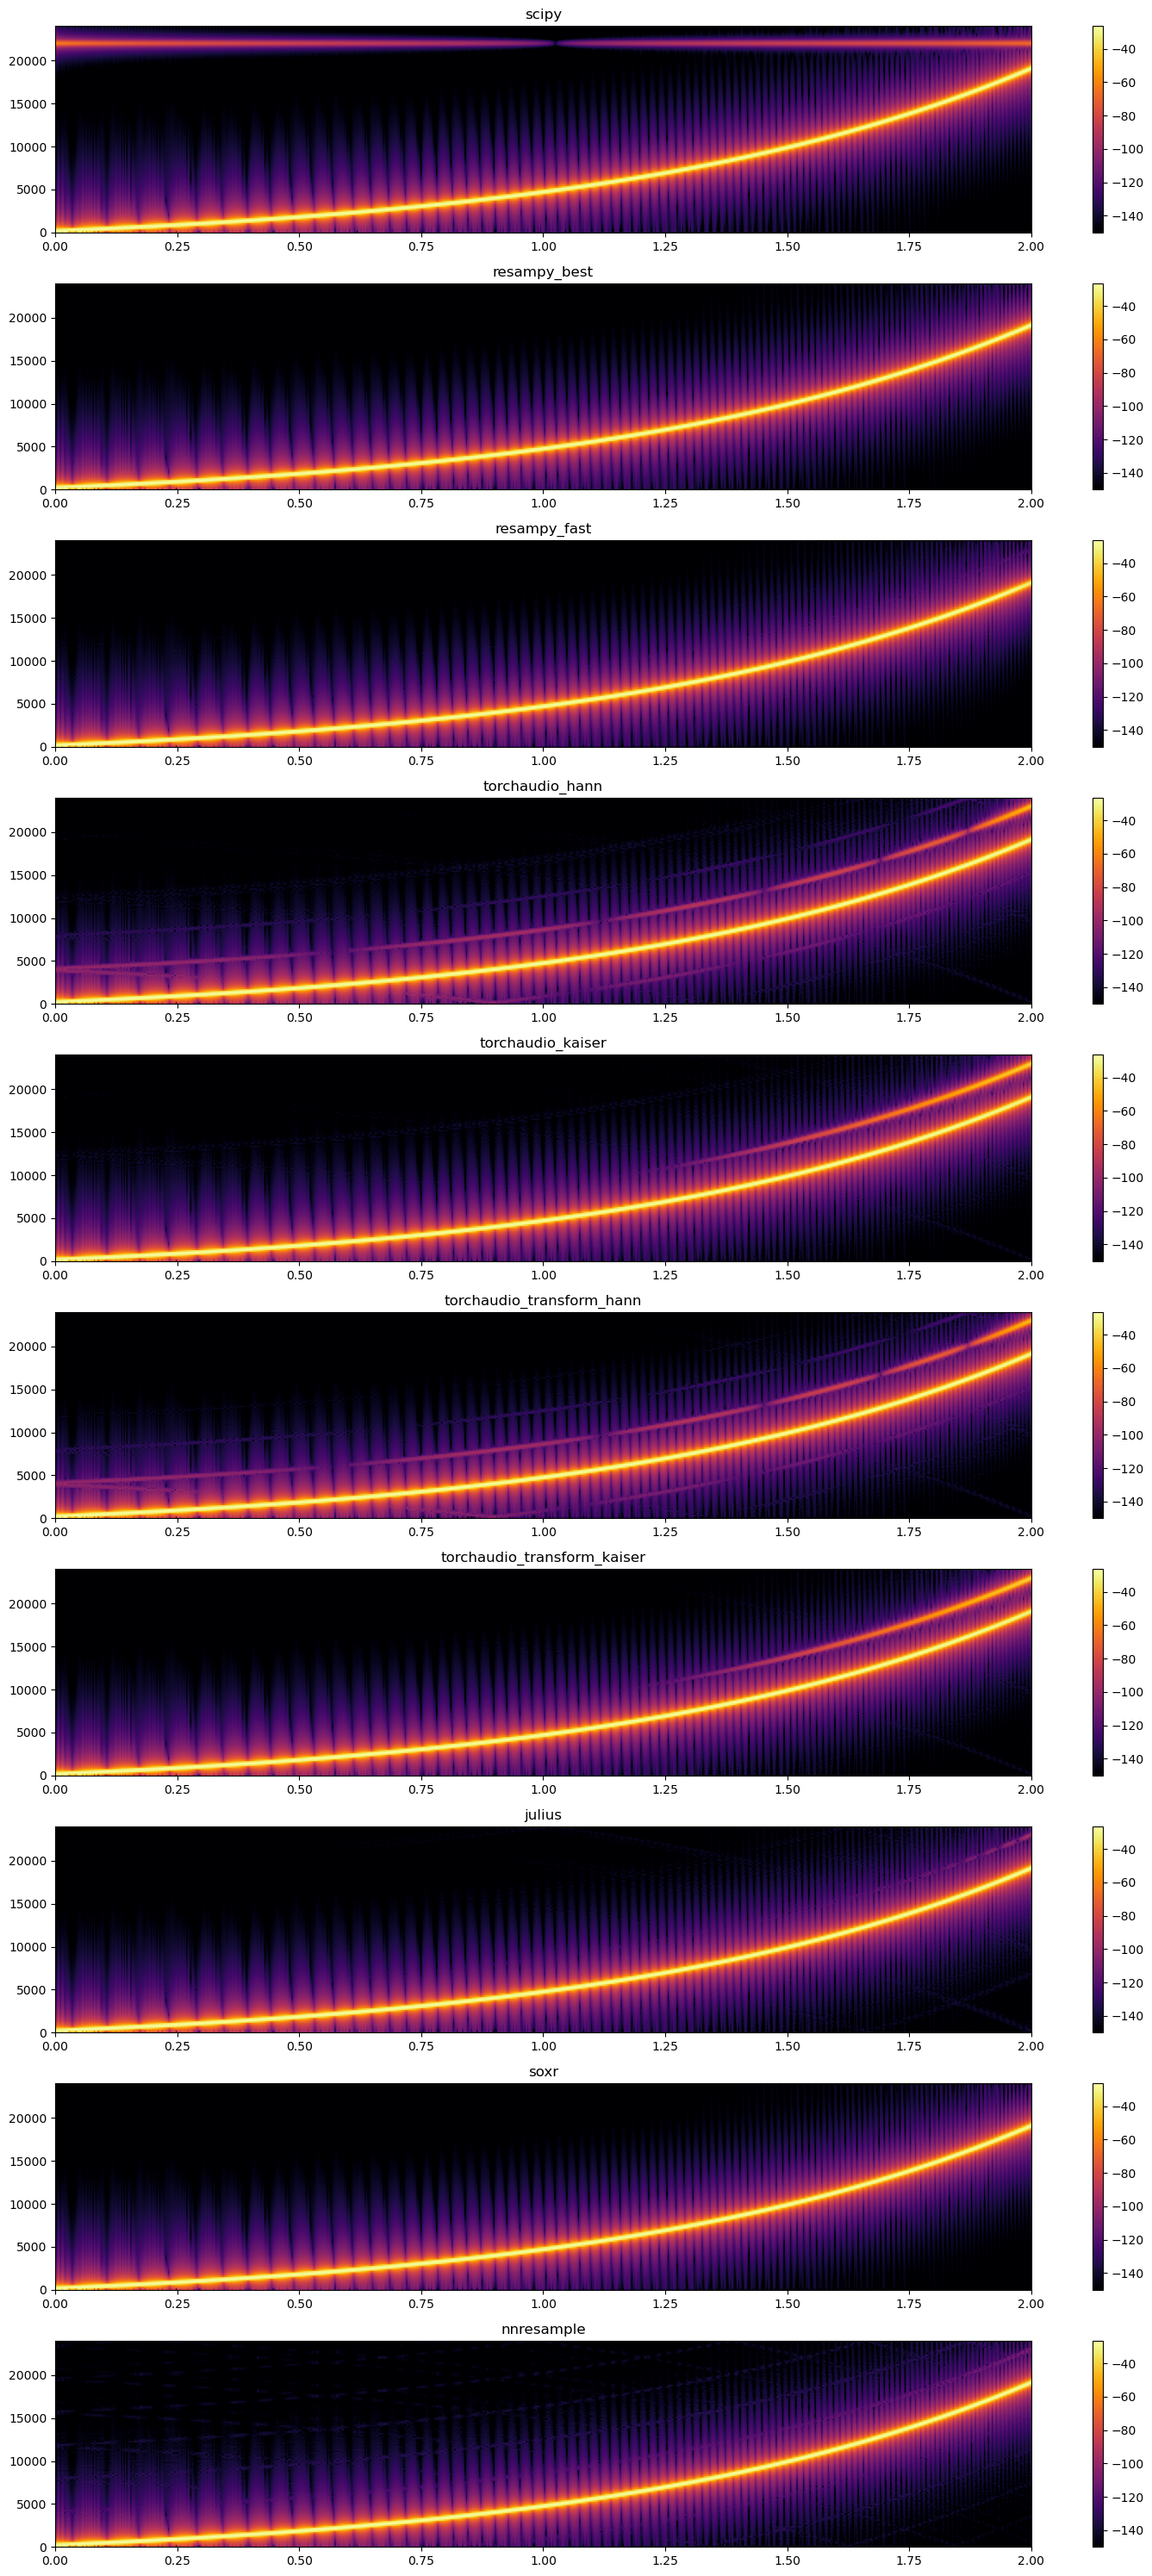

In [11]:
# Upsample using all methods and plot in different subplots

libs = resamp_libs # Change this to select which libraries to use

plt.figure(figsize=(15,30))
for i, lib in enumerate(libs):
    plt.subplot(len(libs), 1, i+1)
    # if torchaudio or julius convert to torch
    _sig = sig
    if lib.startswith('torchaudio') or lib.startswith('julius'):
        _sig = torch.from_numpy(sig).float()
        
    plt.specgram(eval(f'resample_{lib}(_sig, P, Q)'), scale='dB', Fs=Q, vmin=VMIN, cmap='inferno')
    plt.colorbar()
    plt.axis((0,2,0,Q/2))
    plt.title(lib)

plt.tight_layout()

---

## Upsampling an impulse

A way to examine the antialias filter is to upsample an impulse.  Here, note a frustrating aspect of all these differing libraries: the interface is completely different beween all of them; and to boot, `resampy` and `scikit.resample` give different length outputs for the same upsampling ratio.  This means you can't just switch between them using a `from foo import resample` statement, you'll need a wrapper function if you want to switch freely amongst them (see `librosa` as an example).

In [12]:
P = 48000
Q = 44100

impulse = np.zeros(1000)
impulse[499] = 1

libs = resamp_libs # Change this to select which libraries to use

us = {}
for lib in libs:
    # if torchaudio or julius convert to torch
    _impulse = impulse
    if lib.startswith('torchaudio') or lib.startswith('julius'):
        _impulse = torch.from_numpy(impulse).float()
    us[lib] = eval(f'resample_{lib}(_impulse, Q, P)')

print('Impulse responses shape:')
for lib in libs:
    print(f'{lib}: {us[lib].shape}')


Impulse responses shape:
scipy: (1088,)
resampy_best: (1088,)
resampy_fast: (1088,)
torchaudio_hann: torch.Size([1089])
torchaudio_kaiser: torch.Size([1089])
torchaudio_transform_hann: torch.Size([1089])
torchaudio_transform_kaiser: torch.Size([1089])
julius: torch.Size([1088])
soxr: (1088,)
nnresample: (1089,)


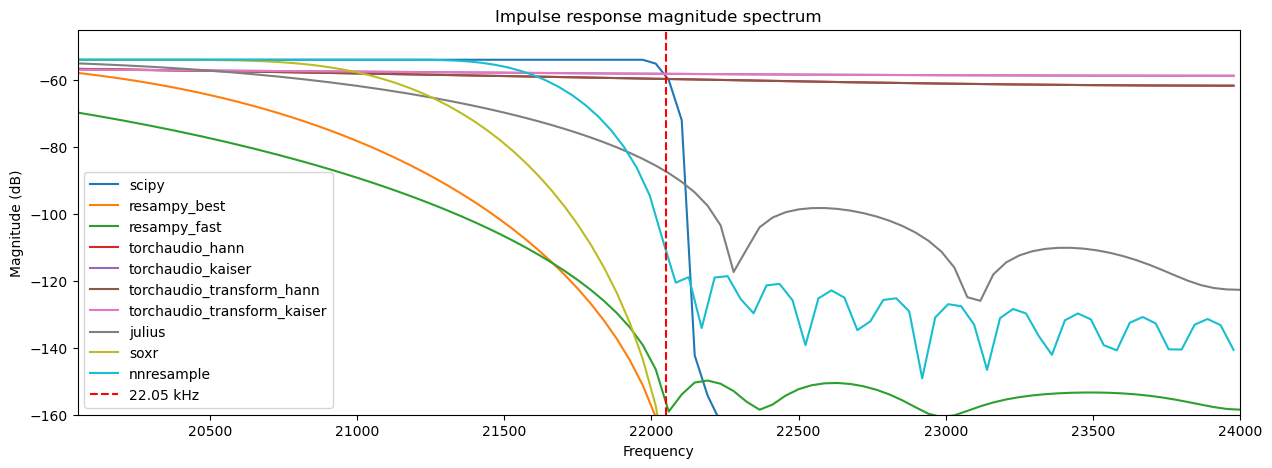

In [13]:

plt.figure(figsize=(15,5) )
for i, lib in enumerate(libs):
    plt.magnitude_spectrum(us[lib], Fs=P, scale='dB', color=f'C{i}', label=lib)

plt.legend()
plt.title('Impulse response magnitude spectrum')
plt.axis((Q/2 - 2000, P/2, -160, -45))
_=plt.vlines(Q/2, -160, 3, colors='r', linestyles='dashed', label='22.05 kHz')
_=plt.legend(loc='lower left')

What do the impulse responses look like in time domain?

/tmp/ipykernel_35379/3234103853.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.square(us[lib])), color=f'C{i}', label=lib)


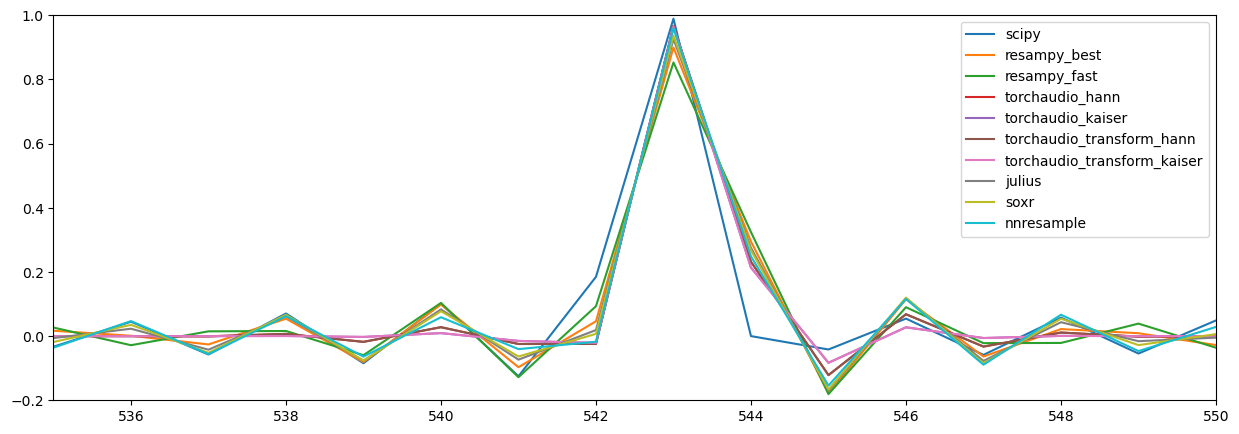

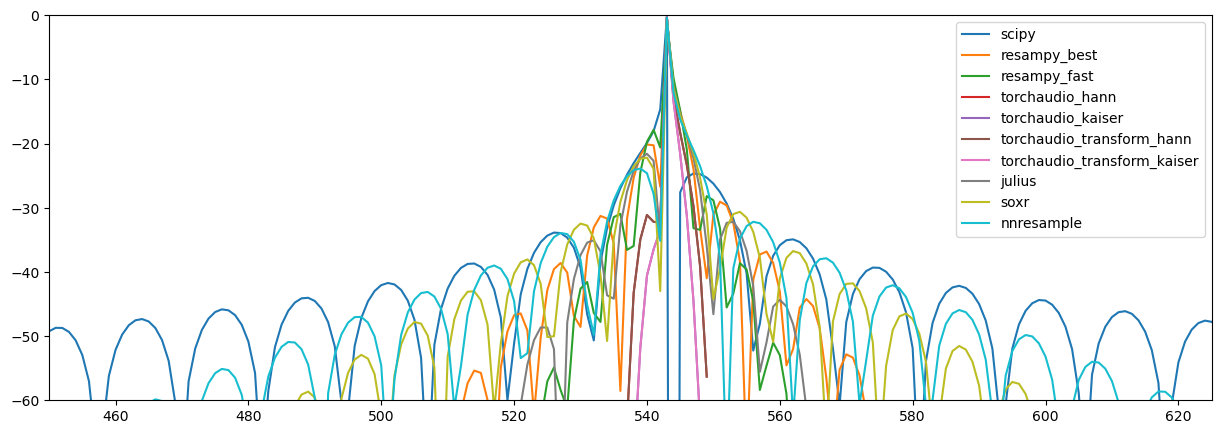

In [14]:
plt.figure(figsize=(15,5) )
for i, lib in enumerate(libs):
    plt.plot(us[lib], color=f'C{i}', label=lib)

plt.axis((535, 550, -0.2, 1))
plt.legend()

plt.figure(figsize=(15,5) )
for i, lib in enumerate(libs):
    plt.plot(10*np.log10(np.square(us[lib])), color=f'C{i}', label=lib)

plt.axis((450, 625, -60, 0))
_=plt.legend()

---

## Speed comparison

In [15]:
for lib in resamp_libs:
    print(f'{lib}: ', end='')
    %timeit eval(f'resample_{lib}(sig, P, Q)') 

scipy: 2.36 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
resampy_best: 38.4 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
resampy_fast: 13.6 ms ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
torchaudio_hann: 963 µs ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
torchaudio_kaiser: 1.19 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
torchaudio_transform_hann: 1.13 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
torchaudio_transform_kaiser: 1.76 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
julius: 9.32 ms ± 567 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
soxr: 1.42 ms ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
nnresample: 18.4 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
# Run everything using timeit and put results in a table
import pandas as pd
import timeit

P = 48000
Q = 44100

signal = sig

# Benchmarks speed of all resampling methods for a given signal
def benchmark_all(sig, P, Q, libs=resamp_libs, n=1000):
    """ Run speed benchmarks for all resampling methods individually
    and return a dataframe with results. """
   
    times = {}
    for lib in libs:
        # if torchaudio or julius convert to torch
        _sig = sig
        if lib.startswith('torchaudio') or lib.startswith('julius'):
            _sig = torch.from_numpy(sig).float()
        print(f'Running {lib}...', end='')
        times[lib] = timeit.timeit(f'resample_{lib}(_sig, P, Q)', number=n, globals=globals())
        print (times[lib], end='')
        print('Done')

    print('---------------')
    # Create a dataframe with results, use concat
    df = pd.DataFrame(columns=['lib', 'time (ms)'])
    for lib in libs:
        # Conver time to ms
        times[lib] = times[lib] * 1000 / n
        df = pd.concat([df, pd.DataFrame({'lib': [lib], 'time (ms)': [times[lib]]})], ignore_index=True)
    
    # Remove index column
    # df = df.reset_index(drop=True)
    return df


In [17]:
print(f'Resampling {len(sig)} samples from {P} to {Q} Hz')

# Run benchmarks for different signals
df = benchmark_all(sig, P, Q, n=1000)

Resampling 96000 samples from 48000 to 44100 Hz
Running scipy...2.402701001999958Done
Running resampy_best...38.03967440600172Done
Running resampy_fast...13.628312748998724Done
Running torchaudio_hann...0.8695082019985421Done
Running torchaudio_kaiser...1.689247594000335Done
Running torchaudio_transform_hann...

In [ ]:
df.sort_values(by='time (ms)', ascending=True)